In [7]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *
import requests
from sklearn.metrics import *
import warnings
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
import CONSTANTS
from audioread.ffdec import ReadTimeoutError
from functions import *
warnings.filterwarnings('ignore')

In [8]:
KEY = "98464488-2db9-4ddc-9b98-6b48f8b623dc" # do not change
LIMIT = 365
COIN = 'BTC'

In [9]:
def prices(product_id, period=30, granularity=86400, start=None, end=None):
    """
    Fetch historical candlestick data for a cryptocurrency pair from now to the specified number of days in the past.

    :param product_id: The product ID for the crypto pair (e.g., 'BTC-USD').
    :param period: Number of days of historical data to fetch.
    :param granularity: Desired time slice in seconds (60, 300, 900, 3600, 21600, 86400).
    :return: DataFrame containing historical data.
    """
    if not product_id.endswith('-USD'):
        product_id += '-USD'
    product_id = product_id.upper()
    url = f"https://api.exchange.coinbase.com/products/{product_id}/candles"
    if start is None and end is None: # get data from specified number of days ago if date bounds are not specified.
        end = datetime.now()
        start = end - timedelta(days=period)
    coin = product_id.split('-')[0]
    all_data = []

    while start < end:
        end_slice = min(start + timedelta(seconds=granularity * 300), end)
        params = {
            'start': start.isoformat(),
            'end': end_slice.isoformat(),
            'granularity': granularity
        }

        try:
            response = requests.get(url, params=params)
        except ConnectionError:
            print("No internet connection")
            return None, coin
        except ReadTimeoutError:
            print('Your wifi likely doesn\'t allow to access Coinbase API')
            return None, coin

        if response.status_code == 200:
            data = response.json()
            all_data.extend(data)
        else:
            print("Failed to fetch data:", response.text)
            break

        start = end_slice

    if all_data:
        columns = ['time', 'low', 'high', 'open', 'close', 'volume']
        data = pd.DataFrame(all_data, columns=columns)
        data['time'] = pd.to_datetime(data['time'], unit='s')
        data['change'] = data['close'] - data['open']
        data['pct_change'] = (data['change'] / data['open']) * 100
        return data, coin
    return None, coin

In [11]:
df, coin = prices(COIN, period=365)

In [23]:
df

,time,low,high,open,close,volume,change,pct_change
0,2025-02-11,94831.07,98500.00,97451.66,95774.08,7737.051057,-1677.58,-1.721448
1,2025-02-10,95257.20,98367.23,96481.47,97444.41,6375.725391,962.94,0.998057
2,2025-02-09,94730.67,97342.28,96476.24,96475.82,3417.870097,-0.42,-0.000435
3,2025-02-08,95682.33,96919.05,96536.93,96476.25,2972.457152,-60.68,-0.062857
4,2025-02-07,95614.96,100235.79,96575.24,96537.08,12171.825342,-38.16,-0.039513
...,...,...,...,...,...,...,...,...
360,2025-02-16,96057.68,97738.22,97596.54,96119.88,2174.293269,-1476.66,-1.513025
361,2025-02-15,97225.01,97997.85,97507.94,97596.94,1626.519291,89.00,0.091275
362,2025-02-14,96268.56,98890.11,96625.29,97509.03,7744.676401,883.74,0.914605
363,2025-02-13,95220.00,98100.00,97864.28,96625.29,6803.607893,-1238.99,-1.266029


## Find the FGI change and close price change correlation

Do this for all the coins

In [24]:
def get_fgi_data():
  url = f'https://pro-api.coinmarketcap.com/v3/fear-and-greed/historical?CMC_PRO_API_KEY={KEY}&limit={LIMIT}'
  json = requests.get(url)
  if json.status_code == 200:
      data = json.json()
      fgi_df = pd.DataFrame(data['data'])
      fgi_df['timestamp'] = pd.to_datetime(fgi_df['timestamp'], unit='s')
      return fgi_df
  else:
    print("Couldn\'t get FGI data with status code" + str(json.status_code))
    return None

In [25]:
def fgi_close_association(coin='BTC'):
  try:
    coinPrices, i = prices(coin, period=LIMIT)
  except:
    print('Invalid coin: ', coin)
    print('Period: ', LIMIT)
    return None
  url = f'https://pro-api.coinmarketcap.com/v3/fear-and-greed/historical?CMC_PRO_API_KEY={KEY}&limit={LIMIT}'
  json = requests.get(url)
  if json.status_code == 200:
      data = json.json()
      fgi_df = pd.DataFrame(data['data'])
  else:
    print("Couldn\'t get FGI data with status code" + str(json.status_code))
    return None

  # convert timestamp to date
  fgi_df['timestamp'] = pd.to_datetime(fgi_df['timestamp'], unit='s')

  # inner join the prices on the timestamp
  everything = pd.merge(coinPrices, fgi_df, left_on='time', right_on='timestamp', how='inner')
  everything = pd.get_dummies(everything)

  # create pct_change for the fgi value
  everything['fgi_pct_change'] = everything['value'].pct_change()
  everything['fgi_pct_change'].fillna(0, inplace=True)
  everything['pct_change'].fillna(0, inplace=True)
  correlation = everything.corr()
  item1 = correlation['pct_change']['fgi_pct_change']
  item2 = np.sqrt(mean_squared_error(everything['pct_change'], everything['fgi_pct_change']))
  return {
      'coin': coin,
      'correlation': item1,
      'RMSE': item2
  }

In [26]:
coins = ['BTC', 'NEAR', 'ETH', 'AVAX', 'SOL', 'ICP', 'FET']
correlations = [fgi_close_association(coin) for coin in coins]
everything = pd.DataFrame(correlations).sort_values(by='RMSE', ascending=True)

In [27]:
import altair as alt

# Sort the DataFrame by RMSE in ascending order
everything_sorted = everything.sort_values('RMSE')

# Create the bar plot
alt.Chart(everything_sorted).mark_bar().encode(
    x=alt.X('coin', sort= 'y'),  # Sort x-axis (coins) by y-axis (RMSE)
    y='RMSE'
).properties(
    title='RMSE by Coin'  # Add a title to the chart
)

alt.Chart(...)

In [28]:
# Sort the DataFrame by RMSE in ascending order
everything_sorted = everything.sort_values('correlation')
everything_sorted['abs_correlation'] = np.abs(everything_sorted['correlation'])

# Create the bar plot
alt.Chart(everything_sorted).mark_bar().encode(
    x=alt.X('coin', sort= 'y'),  # Sort x-axis (coins) by y-axis (RMSE)
    y='abs_correlation'
).properties(
    title='Correlation Magnitude by Coin'  # Add a title to the chart
)

alt.Chart(...)

## Crypto market collector

In [29]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Constants

# -------------------------------
# 1. Market-Faceted Metrics
# -------------------------------

def get_global_market_data():
    """
    Fetch overall market data such as total market capitalization, trading volume, and Bitcoin dominance.
    Purpose: Helps understand the overall health and activity of the cryptocurrency market.
    """
    url = f"https://pro-api.coinmarketcap.com/v1/global-metrics/quotes/latest"
    headers = {
        'X-CMC_PRO_API_KEY': KEY
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        return {
            'total_market_cap': data['data']['quote']['USD']['total_market_cap'],
            'total_volume_24h': data['data']['quote']['USD']['total_volume_24h'],
            'btc_dominance': data['data']['btc_dominance'],
            'active_cryptocurrencies': data['data']['active_cryptocurrencies']
        }
    else:
        print(f"Failed to fetch global market data: {response.status_code}")
        return None

def get_tokenomics(coin):
    """
    Fetch tokenomics data such as circulating supply and total supply.
    Purpose: Helps understand the supply dynamics of a coin, which can influence its price.
    """
    url = f"https://pro-api.coinmarketcap.com/v1/cryptocurrency/info"
    headers = {
        'X-CMC_PRO_API_KEY': KEY
    }
    params = {
        'symbol': coin
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        data = response.json()
        supply_data = data['data'][coin]
        return supply_data
    else:
        print(f"Failed to fetch tokenomics for {coin}: {response.status_code}")
        return None

# -------------------------------
# Additional Metrics
# -------------------------------


# Example Usage
if __name__ == "__main__":
    # Fetch global market data
    market_data = get_global_market_data()
    print("Market Data:", market_data)

    # Fetch tokenomics data
    tokenomics_data = get_tokenomics('BTC')
    print("Tokenomics:", tokenomics_data)


Market Data: {'total_market_cap': 2684168655372.347, 'total_volume_24h': 67833584927.1, 'btc_dominance': 62.99596329072, 'active_cryptocurrencies': 9880}
Tokenomics: {'id': 1, 'name': 'Bitcoin', 'symbol': 'BTC', 'category': 'coin', 'description': 'Bitcoin (BTC) is a cryptocurrency launched in 2010. Users are able to generate BTC through the process of mining. Bitcoin has a current supply of 19,852,700. The last known price of Bitcoin is 85,113.63803793 USD and is up 2.16 over the last 24 hours. It is currently trading on 12039 active market(s) with $24,055,680,644.93 traded over the last 24 hours. More information can be found at https://bitcoin.org/.', 'slug': 'bitcoin', 'logo': 'https://s2.coinmarketcap.com/static/img/coins/64x64/1.png', 'subreddit': 'bitcoin', 'notice': '', 'tags': ['mineable', 'pow', 'sha-256', 'store-of-value', 'state-channel', 'coinbase-ventures-portfolio', 'three-arrows-capital-portfolio', 'polychain-capital-portfolio', 'binance-labs-portfolio', 'blockchain-capi

In [30]:
pd.json_normalize(tokenomics_data)

,id,name,symbol,category,description,slug,logo,subreddit,notice,tags,...,urls.website,urls.twitter,urls.message_board,urls.chat,urls.facebook,urls.explorer,urls.reddit,urls.technical_doc,urls.source_code,urls.announcement
0,1,Bitcoin,BTC,coin,Bitcoin (BTC) is a cryptocurrency launched in ...,bitcoin,https://s2.coinmarketcap.com/static/img/coins/...,bitcoin,,"[mineable, pow, sha-256, store-of-value, state...",...,[https://bitcoin.org/],[],[https://bitcointalk.org],[],[],"[https://blockchain.info/, https://live.blockc...",[https://reddit.com/r/bitcoin],[https://bitcoin.org/bitcoin.pdf],[https://github.com/bitcoin/bitcoin],[]


In [31]:
pd.json_normalize(market_data)

,total_market_cap,total_volume_24h,btc_dominance,active_cryptocurrencies
0,2.684169e+12,6.783358e+10,62.995963,9880


# Steps to train LSTM to predict buy and sell



1.   Obtain additional metrics

* Moving averages (short-term and long-term)
* Relative Strength Index (RSI)
* Moving Average Convergence Divergence (MACD)
* Bollinger Bands
* Volume indicators

2.   Model Approaches

* Classification
  * label buys, sells, holds (1, -1, 0) based on market data
  * predict each label

* Regression
  * predict return over time
    * look at windows of time to find optimal profits
  * identify buy and sell periods



### Generate Metrics

In [32]:
import pandas as pd
import numpy as np

# Assume you have already fetched data using your prices() function,
# and that your DataFrame (df) has at least the following columns:
# ['time', 'low', 'high', 'open', 'close', 'volume']

# ----------------------------
# 1. Moving Averages (SMA & EMA)
# ----------------------------
# Short-term SMA (20 periods) and long-term SMA (50 periods)
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()

# Exponential Moving Averages (optional, can be used in place of or along with SMAs)
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()

# ----------------------------
# 2. Relative Strength Index (RSI)
# ----------------------------
def compute_rsi(series, window=14):
    delta = series.diff()
    # Separate positive and negative gains
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Simple moving average over 'window' periods for gains/losses
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()

    # Alternatively, one can use exponential weighting:
    # avg_gain = gain.ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    # avg_loss = loss.ewm(alpha=1/window, min_periods=window, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df['close'], window=14)

# ----------------------------
# 3. Moving Average Convergence Divergence (MACD)
# ----------------------------
# Calculate the 12-period and 26-period EMA of the closing price
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()

# MACD line: difference between the 12-EMA and 26-EMA
df['MACD'] = df['EMA_12'] - df['EMA_26']

# Signal line: 9-period EMA of the MACD line
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# MACD Histogram: the difference between MACD and its signal line
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

# ----------------------------
# 4. Bollinger Bands
# ----------------------------
# Bollinger Bands are typically computed using a moving average and standard deviation.
# Here we use the 20-period SMA (which we already computed) and a factor of 2 standard deviations.
df['BB_Middle'] = df['SMA_20']  # Middle band is the 20-period SMA
df['BB_STD'] = df['close'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_STD']
df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_STD']

# Optionally, you can drop the intermediate 'BB_STD' column later if not needed:
# df.drop(columns=['BB_STD'], inplace=True)

# ----------------------------
# 5. Volume Indicators
# ----------------------------
# Example 1: 20-period moving average of volume (helps smooth out spikes)
df['Volume_MA_20'] = df['volume'].rolling(window=20).mean()

# Example 2: On-Balance Volume (OBV)
# OBV is designed to relate volume flow to price change.
# We'll start OBV at zero and add/subtract volume depending on price movement.
df['daily_return'] = df['close'].pct_change()  # percentage change in closing price
df['direction'] = np.where(df['daily_return'] > 0, 1, -1)  # +1 for up days, -1 for down days
df.loc[df['daily_return'].isna(), 'direction'] = 0  # set initial value to 0
df['OBV'] = (df['volume'] * df['direction']).fillna(0).cumsum()

# Clean up temporary columns
df.drop(columns=['daily_return', 'direction'], inplace=True)

# ----------------------------
# View the final DataFrame with the newly computed technical indicators
# ----------------------------
df.tail()

# If you wish to inspect or plot these indicators (for example, overlaying Bollinger Bands on price),
# you can use matplotlib, seaborn, or a plotting library of your choice.

,time,low,high,open,close,volume,change,pct_change,SMA_20,SMA_50,...,EMA_26,MACD,MACD_Signal,MACD_Hist,BB_Middle,BB_STD,BB_Upper,BB_Lower,Volume_MA_20,OBV
360,2025-02-16,96057.68,97738.22,97596.54,96119.88,2174.293269,-1476.66,-1.513025,91280.0280,86778.8670,...,90621.758922,3294.991126,2863.096212,431.894914,91280.0280,4980.526561,101241.081121,81318.974879,15033.637482,-148214.667870
361,2025-02-15,97225.01,97997.85,97507.94,97596.94,1626.519291,89.00,0.091275,91822.0260,87163.3908,...,91138.439002,3344.494115,2959.375793,385.118323,91822.0260,5051.718983,101925.463966,81718.588034,13758.103335,-146588.148580
362,2025-02-14,96268.56,98890.11,96625.29,97509.03,7744.676401,883.74,0.914605,92201.3850,87443.6064,...,91610.334631,3338.151852,3035.131005,303.020848,92201.3850,5184.645903,102570.676805,81832.093195,13480.193405,-154332.824981
363,2025-02-13,95220.00,98100.00,97864.28,96625.29,6803.607893,-1238.99,-1.266029,92502.4630,87698.9090,...,91981.812807,3224.643449,3073.033493,151.609955,92502.4630,5261.258526,103024.980052,81979.945948,13075.327101,-161136.432873
364,2025-02-12,94066.92,98119.98,95770.95,97862.53,9078.503562,2091.58,2.183940,93033.0915,87992.6730,...,92417.421488,3197.661498,3097.959094,99.702403,93033.0915,5238.753280,103510.598060,82555.584940,12372.733730,-152057.929312


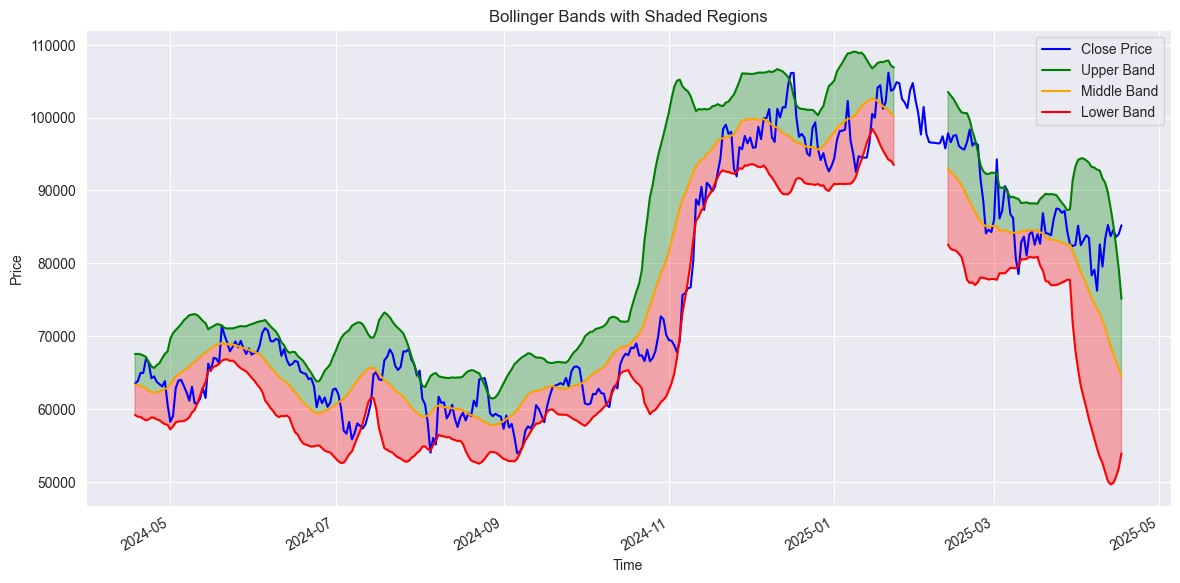

In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure the DataFrame is sorted by time
df = df.sort_values('time').reset_index(drop=True)

# Optionally drop rows with NaNs in Bollinger Bands, if any (depends on your data)
# df = df.dropna(subset=['BB_Upper', 'BB_Middle', 'BB_Lower'])

fig, ax = plt.subplots(figsize=(14, 7))

# Plot the price and Bollinger Bands
ax.plot(df['time'], df['close'], label='Close Price', color='blue')
ax.plot(df['time'], df['BB_Upper'], label='Upper Band', color='green')
ax.plot(df['time'], df['BB_Middle'], label='Middle Band', color='orange')
ax.plot(df['time'], df['BB_Lower'], label='Lower Band', color='red')

# Shade the area between the upper and middle bands
ax.fill_between(df['time'], df['BB_Upper'], df['BB_Middle'], color='green', alpha=0.3)
# Shade the area between the middle and lower bands
ax.fill_between(df['time'], df['BB_Middle'], df['BB_Lower'], color='red', alpha=0.3)

ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Bollinger Bands with Shaded Regions')
ax.legend()
ax.grid(True)

# Optional: improve formatting of x-axis dates
fig.autofmt_xdate()
plt.show()

In [38]:
df.to_csv(fullDataPath(coin), index=False)

## Utilize in model:


* Sentiment Metrics
  * bias
  * sentiment score
* Bollinger Mid Band
* Bias
* Close Price (low weight)
* Volatility

### Steps:



1.   Get articles about a specific coin
2.   Run sentiment analysis on news articles
3.   Calculate volatility
4.   Run LSTM model and/or NN






## Get the news articles for a particular coin

In [58]:
btc_newspapers = pd.read_csv('BTC_newspapers.csv')
btc_newspapers['date'] = pd.to_datetime(btc_newspapers['date'], format="%m/%d/%Y, %I:%M %p, %z UTC")
btc_newspapers['date'] = btc_newspapers['date'].dt.date

In [59]:
df['time']

0     2024-04-18
1     2024-04-19
2     2024-04-20
3     2024-04-21
4     2024-04-22
         ...    
360   2025-04-13
361   2025-04-14
362   2025-04-15
363   2025-04-16
364   2025-04-17
Name: time, Length: 365, dtype: datetime64[ns]

In [92]:
# Ensure both columns are of the same type
df['time'] = pd.to_datetime(df['time'])  # Convert 'time' to datetime
btc_newspapers['date'] = pd.to_datetime(btc_newspapers['date'])  # Convert 'date' to datetime
merged_df = pd.merge(df, btc_newspapers, left_on='time', right_on='date', how='left')
merged_df

,time,low,high,open,close,volume,change,pct_change,SMA_20,SMA_50,...,Volume_MA_20,OBV,Unnamed: 0.1,Unnamed: 0,title,date,link,text,sentiment,score
0,2024-04-18,60816.07,64210.00,61275.73,63513.85,15249.842114,2238.12,3.652539,63384.6340,65477.6480,...,11743.690520,-171947.807670,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,2024-04-19,59573.32,65498.99,63514.84,63848.37,22838.079342,333.53,0.525121,63267.4180,65593.8616,...,11355.519713,-156697.965555,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,2024-04-20,63121.15,65463.08,63841.96,64968.87,5157.407265,1126.91,1.765156,63228.6780,65702.9752,...,10631.618515,-133859.886214,154.0,154.0,A dot-com entrepreneur who once lost $6 billio...,2024-04-20,https://fortune.com/crypto/2024/04/20/michael-...,© 2025 Fortune Media IP Limited. All Rights Re...,neutral,-0.002954
3,2024-04-21,64250.00,65725.81,64960.82,64952.92,4487.487232,-7.90,-0.012161,63019.6080,65796.3552,...,10949.304647,-139017.293479,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,2024-04-22,64520.00,67272.73,64952.92,66859.17,10977.051786,1906.25,2.934818,62812.6935,65887.2514,...,10841.833691,-134529.806247,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,2025-04-16,83088.02,85526.40,83622.52,84028.72,8243.059013,406.20,0.485754,65573.5735,66024.8888,...,11339.592079,-176279.184625,89.0,89.0,Oklahoma exits Bitcoin Reserve Race after taxa...,2025-04-16,https://crypto.news/oklahoma-exits-bitcoin-res...,\n Share \nOklahoma’s proposed Strat...,neutral,0.001982
433,2025-04-16,83088.02,85526.40,83622.52,84028.72,8243.059013,406.20,0.485754,65573.5735,66024.8888,...,11339.592079,-176279.184625,92.0,92.0,Peter Schiff Says Since Trump Was Elected Bitc...,2025-04-16,https://www.benzinga.com/markets/cryptocurrenc...,Benzinga Rankings give you vital metrics on an...,neutral,0.002130
434,2025-04-16,83088.02,85526.40,83622.52,84028.72,8243.059013,406.20,0.485754,65573.5735,66024.8888,...,11339.592079,-176279.184625,161.0,161.0,MSTR Outshines Magnificent 7 With 133% 1-Year ...,2025-04-16,https://cryptopotato.com/mstr-outshines-magnif...,Strategy’s Bitcoin playbook has seen it outper...,neutral,0.011212
435,2025-04-16,83088.02,85526.40,83622.52,84028.72,8243.059013,406.20,0.485754,65573.5735,66024.8888,...,11339.592079,-176279.184625,162.0,162.0,Should You Sell Your Bitcoin for Gold? Top Ana...,2025-04-16,https://coinpedia.org/news/gold-price-hit-all-...,Search keywords to find relevant posts.\nSearc...,neutral,0.011069


In [93]:
def myFillNa(df):
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col].fillna(0, inplace=True)
        elif pd.api.types.is_string_dtype(df[col]) or pd.api.types.is_object_dtype(df[col]):
            df[col].fillna(CONSTANTS.EMPTY_STRING, inplace=True)
        else:
            df[col].fillna(np.nan, inplace=True)

myFillNa(merged_df)

In [95]:
merged_df.to_csv(fullDataPath(coin), index=False)

NameError: name 'fullDataPath' is not defined

In [97]:
merged_df.to_csv(f'fulldata/{coin}_df.csv', index=False)